In [17]:
import sys
sys.path.append("..")
from models.CTTS import CTTS
from tqdm import tqdm

import torch 
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## So all the DL assignments so far we've used pretty standard datasets like CIFAR and MNIST you can just download using torch.datasets and then pass that to a DataLoader to generate the batches. This time we're using our own dataset so we have to make a custom class for it to pass to the DataLoader. Not sure if this is the best place to put this or if we should just make some utils.py file and put it in there.

In [2]:


class CustomDataset(Dataset):
    def __init__(self, data_dir, label_col, ts_length=80):
        raw_df = pd.read_csv(data_dir)
        data_cols = ['t' + str(i) for i in range(ts_length)]
        df = raw_df[data_cols]
        np_arr = df.values
        np_arr = np.float32(np_arr)
        y = raw_df[label_col].values
        y = np.float32(y)
        self.data = torch.from_numpy(np_arr)
        self.labels = y

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
        

In [ ]:
data_dir_train = "../data/train.csv"
data_dir_test = "../data/test.csv"
label_col = "two_class_label"
train_dataset = CustomDataset(data_dir=data_dir_train,  label_col=label_col, ts_length=80)
test_dataset = CustomDataset(data_dir=data_dir_test, label_col=label_col, ts_length=80)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size  

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)



In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')    
else:
    device = torch.device('cpu')

print(f"Using Device: {device}")

Using Device: cuda


In [5]:
model = CTTS(device=device)

/home/holden/.conda/envs/pytorch_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
learning_rate = 1e-3
optimizer = optim.AdamW(params=model.parameters() ,lr=learning_rate)

criterion = nn.CrossEntropyLoss()

batch_size = 64
max_epochs = 100

## Training loop where we'll record training loss and validation loss so we can make learning curves 

Epoch [1/100], Train Loss: 0.6900, Val Loss: 0.6900
Epoch [2/100], Train Loss: 0.6900, Val Loss: 0.6899
Epoch [3/100], Train Loss: 0.6900, Val Loss: 0.6898
Epoch [4/100], Train Loss: 0.6900, Val Loss: 0.6898
Epoch [5/100], Train Loss: 0.6900, Val Loss: 0.6898
Epoch [6/100], Train Loss: 0.6899, Val Loss: 0.6903
Epoch [7/100], Train Loss: 0.6900, Val Loss: 0.6898
Epoch [8/100], Train Loss: 0.6899, Val Loss: 0.6899
Epoch [9/100], Train Loss: 0.6899, Val Loss: 0.6898
Epoch [10/100], Train Loss: 0.6900, Val Loss: 0.6898
Epoch [11/100], Train Loss: 0.6900, Val Loss: 0.6900
Epoch [12/100], Train Loss: 0.6900, Val Loss: 0.6899
Epoch [13/100], Train Loss: 0.6900, Val Loss: 0.6898
Epoch [14/100], Train Loss: 0.6899, Val Loss: 0.6908
Epoch [15/100], Train Loss: 0.6900, Val Loss: 0.6898
Epoch [16/100], Train Loss: 0.6899, Val Loss: 0.6900
Epoch [17/100], Train Loss: 0.6900, Val Loss: 0.6898
Epoch [18/100], Train Loss: 0.6900, Val Loss: 0.6898
Epoch [19/100], Train Loss: 0.6900, Val Loss: 0.6898
Ep

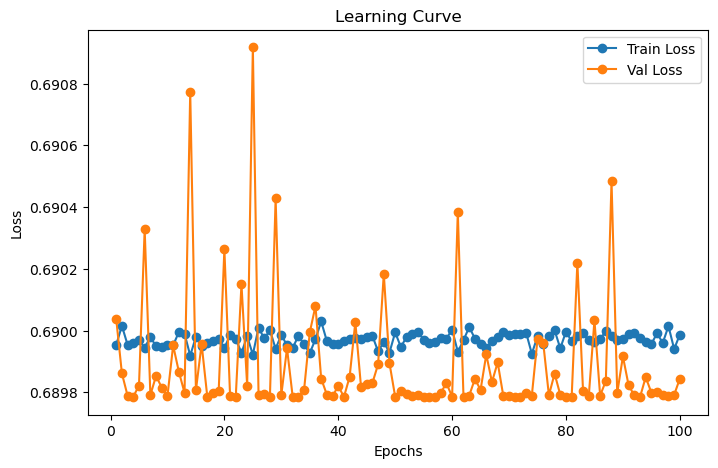

In [18]:
train_losses = []
val_losses = []

for epoch in range(max_epochs):
    model.train()  
    total_train_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        targets = targets.type(torch.LongTensor)
        inputs, targets = inputs.to(device), targets.to(device)
        #print(inputs.dtype)
        inputs = inputs.reshape((inputs.shape[0], 1, 80))
            
        #print(inputs.shape)


        optimizer.zero_grad()  
        outputs = model(inputs) 
        loss = criterion(outputs, targets) 
        loss.backward() 
        optimizer.step() 

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

   
    model.eval() 
    total_val_loss = 0

    with torch.no_grad():  # don't keep track of gradient for validation
        for batch in val_loader:
            inputs, targets = batch
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.reshape((inputs.shape[0], 1, 80))

            outputs = model(inputs)  
            loss = criterion(outputs, targets)  

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(range(1, max_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, max_epochs + 1), val_losses, label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()